In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    roc_curve,
    auc,
    precision_recall_curve,
)

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_data = pd.read_parquet("../data/unadultered/train_data.parquet")
test_data = pd.read_parquet("../data/unadultered/test_data.parquet").reset_index()

In [3]:
def clean_data(data = train_data, debug=True, y_value =True,):
    """Cleans data given in test_data schema

    Args:
        data (test_data schema, optional): Just the typical input data, accepts test_data and train_data. Defaults to test_data.

    Returns:
        _type_: the same train_data database with the appropriate datatypes
    """
    cleaned_data = data
    for col_num in range(1, 367):
        col = "f" + str(col_num)
        print(col+":") if debug else None
        # These columns have strings hence we want to change or drop them soon
        if col_num in [42, 50] + list(range(52, 57)):
            print("pass") if debug else None
            pass
        elif col_num in list(range(226, 310)) + list(range(332, 336)) + [359, 360]:
            cleaned_data[col] = data[col].astype(bool)
            print("bool") if debug else None
        else:
            col_data = pd.to_numeric(
                data[col], errors="coerce"
            )  # converts to numeric, keeps NaN
            # Check if any non-NaN value has decimal part
            if (col_data.dropna() % 1 != 0).any():
                cleaned_data[col] = col_data.astype(float)
                print("bool") if debug else None
            else:
                cleaned_data[col] = col_data.astype("Int64")
                print("Int") if debug else None
                
    # Lastly converting the y-values
    cleaned_data["y"] = data["y"].astype("Int64") if y_value else None
    # Dropping columns that have strings in their values as not yet worked around.
    cleaned_data = cleaned_data.drop(["f42","f50","f52","f53","f54","f55","f56"],axis=1)
    # Filling all the NaN values with 0
    cleaned_data = cleaned_data.fillna(0)
    return cleaned_data

In [9]:
# cleaned Training Data
clean_train_data = clean_data(data=train_data,debug=False,y_value=True)
clean_test_data = clean_data(data=test_data,debug=False,y_value=False)

C:\Users\rohan\AppData\Local\Temp\ipykernel_3180\1744062663.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_data["y"] = data["y"].astype("Int64") if y_value else None
C:\Users\rohan\AppData\Local\Temp\ipykernel_3180\1744062663.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_data = cleaned_data.fillna(0)


In [13]:
# Separate out the y and X from each case
# Splitting the data into the Xdata and Ydata
Xdata = clean_train_data.iloc[:,6:]
Ydata = clean_train_data.iloc[:,5]
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.1)

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

base_model = SGDClassifier(loss='log_loss', random_state=42)
model = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)

model.fit(X_train, y_train)

,estimator,SGDClassifier...ndom_state=42)
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000


In [22]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Log Loss:", log_loss(y_test, y_pred_proba))

AUC: 0.7202515194158507
Log Loss: 0.1844987809983135


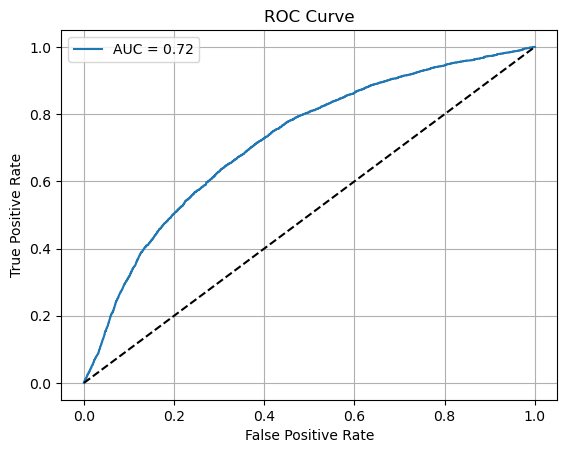

In [23]:
# ROC Curve (Receiver Operating Characteristic)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
np.unique(y_pred_proba)

array([0., 1.])